In [11]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [12]:
# Load data
df = pd.read_excel('data/Monthly Mastersheet.xlsx')

# Ensure date is datetime and set index
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)
df.columns = df.columns.str.strip()

In [21]:
# Assume df['GDP'] is your macro target
# df['Bitcoin_Vol'] is the exogenous predictor
endog = df['GDP'].dropna()
exog = df[['Bitcoin']].shift(1).dropna()  # Lagged 1 month

# Align indices
endog = endog.loc[exog.index]

model = SARIMAX(endog, exog=exog, order=(1,0,0))  # AR(1) with exogenous input
results = model.fit()
print(results.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.08746D+01    |proj g|=  3.05259D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      2      4      1     0     0   1.416D-05   1.087D+01
  F =   10.874579895573092     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                               SARIMAX Results                                
Dep. Variable:                    GDP   No. Observations:                   87
Model:               SARIMAX(1, 0, 0

/Users/anniewang/opt/anaconda3/envs/py39env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/anniewang/opt/anaconda3/envs/py39env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


/Users/anniewang/opt/anaconda3/envs/py39env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/anniewang/opt/anaconda3/envs/py39env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/anniewang/opt/anaconda3/envs/py39env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/anniewang/opt/anaconda3/envs/py39env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


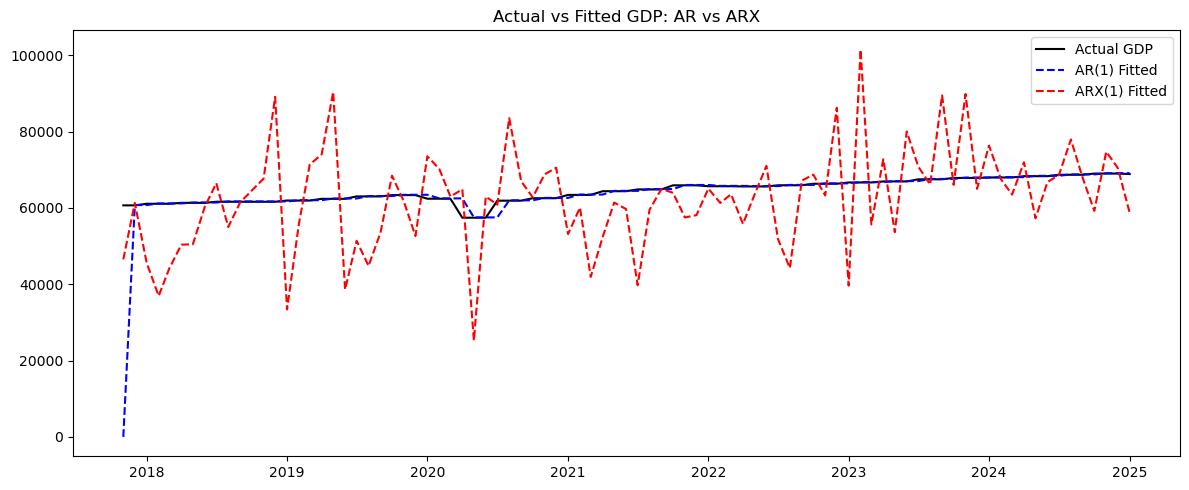

=== Model Comparison ===
AR(1) AIC:  1390.93,  BIC: 1395.84
ARX(1) AIC: 1876.22, BIC: 1883.58


In [22]:

df = df[['GDP', 'Bitcoin']].dropna().copy()
df['Bitcoin_vol_lag1'] = df['Bitcoin'].shift(1)
df = df.dropna()  # Drop NaN from lag

# Separate variables
endog = df['GDP']
exog = df[['Bitcoin_vol_lag1']]

# 1. AR(1) model — GDP only
model_ar = SARIMAX(endog, order=(1, 0, 0), enforce_stationarity=False, enforce_invertibility=False)
results_ar = model_ar.fit(disp=False)

# 2. ARX(1) model — GDP + Bitcoin volatility
model_arx = SARIMAX(endog, exog=exog, order=(1, 0, 0), enforce_stationarity=False, enforce_invertibility=False)
results_arx = model_arx.fit(disp=False)

# 3. Plot Actual vs Fitted for both
plt.figure(figsize=(12, 5))

plt.plot(endog.index, endog, label='Actual GDP', color='black')
plt.plot(endog.index, results_ar.fittedvalues, label='AR(1) Fitted', linestyle='--', color='blue')
plt.plot(endog.index, results_arx.fittedvalues, label='ARX(1) Fitted', linestyle='--', color='red')

plt.title("Actual vs Fitted GDP: AR vs ARX")
plt.legend()
plt.tight_layout()
plt.show()

# 4. Compare AIC, BIC
print("=== Model Comparison ===")
print(f"AR(1) AIC:  {results_ar.aic:.2f},  BIC: {results_ar.bic:.2f}")
print(f"ARX(1) AIC: {results_arx.aic:.2f}, BIC: {results_arx.bic:.2f}")